# PPR

In [ ]:
import json
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np
import igraph as ig
from tqdm import tqdm
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List
import dotenv
import os
import pandas as pd

dotenv.load_dotenv()


GRAPH_INDEX_PATH = "../hippocampal_index.json"
SOURCE_TRIPLES_PATH = "../knowledge_graph_triples_structured.json"
ORIGINAL_CONTEXT_PATH = "../all_context.json"
ENCODER_MODEL_NAME = 'paraphrase-multilingual-MiniLM-L12-v2'
MODEL_NAME = "gpt-4o-mini"
PPR_DAMPING_FACTOR = 0.5 # The lesser the value, the more the algorithm focuses on the local structure of the graph.

In [ ]:
class QueryEntities(BaseModel):
    """A structured list of named entities extracted from a user's query."""
    named_entities: List[str] = Field(
        ...,
        description="A list of named entities that are important for solving the user's question."
    )


class HippoRAGRetriever:
    def __init__(self):
        print("Initializing HippoRAGRetriever...")
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self._load_data()

        self.encoder_model = SentenceTransformer(ENCODER_MODEL_NAME, device=self.device)
        self.llm = ChatOpenAI(
            model=MODEL_NAME, temperature=0, api_key=os.getenv("METIS_API_KEY"), base_url="https://api.metisai.ir/openai/v1"
        )
        
        self._build_graph()
        self._compute_node_specificity()
        self._create_passage_to_node_mapping()

        print("Pre-encoding all graph nodes for retrieval...")
        self.node_labels = [node['label'] for node in self.graph_data['nodes']]
        self.node_embeddings = self.encoder_model.encode(
            self.node_labels, show_progress_bar=True, convert_to_tensor=True
        )
        print("Initialization complete.")

    def _load_data(self):
        """Loads the graph, source triples, and original passages."""
        print("Loading graph index and source data...")
        try:
            with open(GRAPH_INDEX_PATH, 'r', encoding='utf-8') as f:
                self.graph_data = json.load(f)
            with open(SOURCE_TRIPLES_PATH, 'r', encoding='utf-8') as f:
                self.source_triples = json.load(f)
            with open(ORIGINAL_CONTEXT_PATH, 'r', encoding='utf-8') as f:
                self.passages = json.load(f) 
        except FileNotFoundError as e:
            print(f"Error: Could not find a required data file: {e.filename}")
            print("Please ensure all data files from the previous steps are present.")
            exit()

    def _build_graph(self):
        """Builds a weighted igraph.Graph object from the loaded JSON data."""
        print("Building weighted igraph object...")
        self.g = ig.Graph(directed=False)
        self.g.add_vertices(len(self.graph_data['nodes']))
        
        self.node_label_to_id = {node['label']: node['id'] for node in self.graph_data['nodes']}
        
        edges = []
        weights = []
        for edge_data in self.graph_data['edges']:
            source_id = self.node_label_to_id.get(edge_data['source'])
            target_id = self.node_label_to_id.get(edge_data['target'])
            
            if source_id is not None and target_id is not None:
                edges.append((source_id, target_id))
                # Assign weights: similarity score for synonymy, 1.0 for relations
                if edge_data['type'] == 'synonymy':
                    weights.append(edge_data.get('score', 0.8))
                else: 
                    weights.append(1.0)
        
        self.g.add_edges(edges)
        # Assign the weights to the 'weight' edge attribute
        self.g.es['weight'] = weights  
        print(f"Graph built with {self.g.vcount()} vertices and {self.g.ecount()} edges.")

    def _compute_node_specificity(self):
        """
        Calculates node specificity for each node in the graph.
        Specificity s_i = 1 / |P_i|, where P_i is the set of passages containing node i.
        """
        print("Computing node specificity...")
        node_passage_counts = {node_id: 0 for node_id in range(len(self.node_label_to_id))}
        passage_nodes = {}
        for item in self.source_triples:
            passage_id = item['id']
            nodes_in_passage = set(item.get('entities', []))
            for triple in item.get('triples', []):
                nodes_in_passage.add(triple['subject'])
                nodes_in_passage.add(triple['object'])
            
            for node_label in nodes_in_passage:
                node_id = self.node_label_to_id.get(node_label)
                if node_id is not None:
                    if passage_id not in passage_nodes.get(node_id, set()):
                        node_passage_counts[node_id] += 1
                        if node_id not in passage_nodes:
                            passage_nodes[node_id] = set()
                        passage_nodes[node_id].add(passage_id)

        self.node_specificity = {}
        for node_id, count in node_passage_counts.items():
            if count > 0:
                self.node_specificity[node_id] = 1.0 / count
            else:
                self.node_specificity[node_id] = 0 

    def _create_passage_to_node_mapping(self):
        self.passage_to_nodes = {i: [] for i in range(len(self.passages))}
        for item in self.source_triples:
            passage_idx = item['id']
            nodes_in_passage = set(item.get('entities', []))
            for triple in item.get('triples', []):
                nodes_in_passage.add(triple['subject'])
                nodes_in_passage.add(triple['object'])
            
            node_ids_in_passage = {self.node_label_to_id.get(label) for label in nodes_in_passage}
            self.passage_to_nodes[passage_idx] = [nid for nid in node_ids_in_passage if nid is not None]


    def _extract_query_entities(self, query: str) -> List[str]:
        system_prompt = """
        Instruction:
        Your task is to extract named entities from the given paragraph in the user's message.
        Respond with a JSON list of entities.

        One-Shot Demonstration:
        If the user provides the paragraph:
        "Radio City is India's first private FM radio station and was started on 3 July 2001. It plays Hindi, English and regional songs. Radio City recently forayed into New Media in May 2008 with the launch of a music portal - PlanetRadiocity.com that offers music related news, videos, songs, and other music-related features."

        Your output should be a JSON object with a list of the extracted entities:
        {{"named_entities": ["Radio City", "India", "3 July 2001", "Hindi", "English", "May 2008", "PlanetRadiocity.com"]}}
        """
        prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("human", "Question: {query}")
        ])
        chain = prompt | self.llm.with_structured_output(QueryEntities)
        try:
            response = chain.invoke({"query": query})
            return response.named_entities
        except Exception as e:
            print(f"Error extracting query entities: {e}")
            return []
            
    def _find_query_nodes(self, query_entities: List[str]) -> List[int]:
        """Finds the most similar graph nodes for the extracted query entities."""
        if not query_entities:
            return []
        
        global VERBOSE
        
        query_embeddings = self.encoder_model.encode(query_entities, convert_to_tensor=True)
        cos_scores = util.cos_sim(query_embeddings, self.node_embeddings)
        
        # find the node with the highest similarity
        top_matches_indices = torch.argmax(cos_scores, dim=1)
        
        # --- DEBUGGING ADDITION ---
        matched_node_ids = []
        for i, entity in enumerate(query_entities):
            node_id = top_matches_indices[i].item()
            score = cos_scores[i][node_id].item()
            node_label = self.node_labels[node_id]
            if VERBOSE:
                print(f"  - Query Entity: '{entity}' -> Matched Node: '{node_label}' (ID: {node_id}) | Score: {score:.4f}")
            matched_node_ids.append(node_id)
        
        return list(set(matched_node_ids))

    def retrieve(self, query: str, top_k: int = 5) -> List[dict]:
        """
        Performs the full online retrieval process for a given query.
        """
        global VERBOSE
        
        # 1. Neocortex: Extract entities from query
        query_entities = self._extract_query_entities(query)
        if not query_entities:
            print("Could not extract entities from query. Aborting retrieval.")
            return []
        if VERBOSE:
            print(f"Step 1: Extracted query entities -> {query_entities}")

        # 2. Parahippocampal Regions: Find corresponding nodes in the graph
        query_node_ids = self._find_query_nodes(query_entities)
        if not query_node_ids:
            print("Could not find matching nodes in the graph. Aborting retrieval.")
            return []
        query_node_labels = [self.node_labels[i] for i in query_node_ids]
        if VERBOSE:
            print(f"Step 2: Found corresponding query nodes -> {query_node_labels}")

        # 3. Hippocampus: Perform pattern completion with PPR
        personalization_vector = np.zeros(self.g.vcount())
        total_specificity = 0
        for node_id in query_node_ids:
            specificity = self.node_specificity.get(node_id, 0)
            personalization_vector[node_id] = specificity
            total_specificity += specificity
        
        # Normalize the vector so it sums to 1
        if total_specificity > 0:
            personalization_vector /= total_specificity
            
        ppr_scores = self.g.personalized_pagerank(
            vertices=None,
            directed=False,
            damping=PPR_DAMPING_FACTOR,
            reset=personalization_vector.tolist(),
            weights=self.g.es['weight']  
        )

        # --- DEBUGGING ADDITION ---
        
        if VERBOSE:
            print("\n--- DEBUG: Top 10 Nodes after PageRank ---")
            top_node_indices = np.argsort(ppr_scores)[-10:][::-1]
            for node_id in top_node_indices:
                print(f"  - Node: '{self.node_labels[node_id]}' (ID: {node_id}) | PPR Score: {ppr_scores[node_id]:.6f}")
        
        # 4. Aggregate node scores to get passage scores
        passage_scores = {i: 0.0 for i in range(len(self.passages))}
        for passage_idx, node_ids in self.passage_to_nodes.items():
            score = sum(ppr_scores[node_id] for node_id in node_ids)
            passage_scores[passage_idx] = score
            
        sorted_passages = sorted(passage_scores.items(), key=lambda item: item[1], reverse=True)
        
        results = []
        for passage_idx, score in sorted_passages[:top_k]:
            results.append({
                "passage_index": passage_idx,
                "passage_text": self.source_triples[passage_idx]["passage"],
                "score": score
            })
        return results

In [3]:
retriever = HippoRAGRetriever()

Initializing HippoRAGRetriever...
Loading graph index and source data...
Building weighted igraph object...
Graph built with 4644 vertices and 5980 edges.
Computing node specificity...
Pre-encoding all graph nodes for retrieval...


Batches:   0%|          | 0/146 [00:00<?, ?it/s]

Initialization complete.


In [4]:
example_query = "آیا کاترین لانگفورد نقش هانا بیکر را در فصل سوم سریال ۱۳ دلیل برای اینکه بازی کرده است ؟"
VERBOSE = True
top_passages = retriever.retrieve(query=example_query, top_k=15)

print("\n--- Top 5 Retrieved Passages ---")
if top_passages:
    for i, result in enumerate(top_passages):
        print(f"{i+1}. [Score: {result['score']:.6f}] Passage (Index {result['passage_index']}):")
        print(f"   '{result['passage_text'][:200]}...'")
        print("-" * 20)
else:
    print("No passages were retrieved.")

Step 1: Extracted query entities -> ['کاترین لانگفورد', 'هانا بیکر', 'فصل سوم', 'سریال ۱۳ دلیل برای اینکه']
  - Query Entity: 'کاترین لانگفورد' -> Matched Node: 'کاترین لانگفورد' (ID: 3926) | Score: 1.0000
  - Query Entity: 'هانا بیکر' -> Matched Node: 'هانا بیکر' (ID: 3499) | Score: 1.0000
  - Query Entity: 'فصل سوم' -> Matched Node: 'فصل سوم' (ID: 2681) | Score: 1.0000
  - Query Entity: 'سریال ۱۳ دلیل برای اینکه' -> Matched Node: '۱۳ دلیل برای اینکه' (ID: 4278) | Score: 0.8479
Step 2: Found corresponding query nodes -> ['فصل سوم', 'هانا بیکر', '۱۳ دلیل برای اینکه', 'کاترین لانگفورد']

--- DEBUG: Top 10 Nodes after PageRank ---
  - Node: 'فصل سوم' (ID: 2681) | PPR Score: 0.226735
  - Node: '۱۳ دلیل برای اینکه' (ID: 4278) | PPR Score: 0.219418
  - Node: 'کاترین لانگفورد' (ID: 3926) | PPR Score: 0.121785
  - Node: 'هانا بیکر' (ID: 3499) | PPR Score: 0.091013
  - Node: 'نت‌فلیکس' (ID: 3341) | PPR Score: 0.026780
  - Node: 'جی اشر' (ID: 1525) | PPR Score: 0.015935
  - Node: 'توماس مک‌کارت

In [16]:
example_query = "کدام یک از بازیگران فیلم اثر پروانه‌ای در فیلم آینه‌ها نیز ایفای نقش کرده است ؟"
VERBOSE = False
top_passages = retriever.retrieve(query=example_query, top_k=25)

print("\n--- Top 5 Retrieved Passages ---")
if top_passages:
    for i, result in enumerate(top_passages):
        print(f"{i+1}. [Score: {result['score']:.6f}] Passage (Index {result['passage_index']}):")
        print(f"   '{result['passage_text'][:]}...'")
        print("-" * 20)
else:
    print("No passages were retrieved.")


--- Top 5 Retrieved Passages ---
1. [Score: 0.872532] Passage (Index 285):
   'ایمی لیسل اسمارت بازیگر سینما و تلویزیون و مانکن پیشین آمریکایی است.
او حرف مدلینگ را در کشور ایتالیا شروع کرد و سپس وارد مدرسه بازیگری شد.
اولین نقش او در فیلم کمپ‌فایر تیلز به کارگردانی مارتین کونرت بود و از آن زمان به بعد در فیلم‌های متعددی همچون سفر جاده‌ای، اثر پروانه‌ای و آینه‌ها ایفای نقش کرده‌است....'
--------------------
2. [Score: 0.317362] Passage (Index 383):
   'اثر پروانه‌ای فیلمی تریلر روان‌شناختی به نویسندگی و کارگردانی اریک برس و جیمکی گروبر و با بازیگری اشتون کوچر و ایمی اسمارت ، محصول سال ۲۰۰۴ آمریکا است.
داستان فیلم از اثر پروانه‌ای مطرح شده در نظریه آشوب استفاده می‌کند.
نسخه دوم این فیلم هم با نام اثر پروانه‌ای ۲ در سال ۲۰۰۶ ساخته شده‌است و نسخه سوم این فیلم هم با نام اثر پروانه‌ای ۳ سه سال بعد ساخته شد....'
--------------------
3. [Score: 0.029795] Passage (Index 414):
   'پل جرج کلبنیکوف یا پاول یوریویج خلبنیکوف (زادهٔ ۳ ژوئن ۱۹۶۳ - درگذشته ۹ ژوئیه ۲۰۰۴) یک روزنامه‌نگار آمریکایی روسی‌

# RAG pipeline

In [ ]:
class StructuredAnswer(BaseModel):
    final_answer: str = Field(
        description="The final, concise answer to the user's question."
    )

In [ ]:
class QuestionAnsweringSystem:
    def __init__(self, retriever: HippoRAGRetriever):
        self.retriever = retriever
        self.llm = ChatOpenAI(
             model="gpt-4o-mini", temperature=0, api_key=os.getenv("METIS_API_KEY"), base_url="https://api.metisai.ir/openai/v1"
        )
        self.qa_prompt = self._create_qa_prompt()

    def _create_qa_prompt(self):
        answer_types_guidance = [
            "اسامی عام", 
            "شخص", 
            "بلی/خیر", 
            "تاریخ", 
            "رویداد", 
            "مکان", 
            "اسامی خاص دیگر", 
            "شماره", 
            "کار هنری", 
            "گروه یا سازمان", 
            "صفت"
        ]
        
        system_prompt = f"""
        You are an expert Question Answering assistant. Your task is to answer the user's question based *only* on the provided context.
        First, think step-by-step.
        Then, provide a clear and very concise final answer. The answer should be a direct value, like one of the following types: {answer_types_guidance}.

        --- ONE-SHOT EXAMPLE ---
        CONTEXT:
        Passage 1: The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower.
        Passage 2: The construction of the Eiffel Tower began in January 1887 and was completed on 31 March 1889.

        QUESTION:
        When was the Eiffel Tower finished?

        YOUR STRUCTURED OUTPUT:
        {{{{
            "final_answer": "31 March 1889"
        }}}}
        --- END OF EXAMPLE ---
        """

        return ChatPromptTemplate.from_messages([
            ("system", system_prompt),
            ("human", "CONTEXT:\n{context}\n\nQUESTION:\n{question}\n\nYOUR STRUCTURED OUTPUT:")
        ])

    def answer_question(self, query: str, top_k_retrieval: int = 5) -> str:
        # Retrieve relevant passages using HippoRAG
        retrieved_passages = self.retriever.retrieve(query, top_k=top_k_retrieval)
        
        if not retrieved_passages:
            print("No relevant context found. Cannot generate an answer.")
            return "Could not find any relevant information to answer the question."

        context_string = ""
        for i, doc in enumerate(retrieved_passages):
            context_string += f"Passage {i+1} (Score: {doc['score']:.4f}):\n{doc['passage_text']}\n\n"
        
        # Generate the final answer using the LLM with structured output
        structured_chain = self.qa_prompt | self.llm.with_structured_output(StructuredAnswer)
        
        try:
            response = structured_chain.invoke({
                "context": context_string.strip(),
                "question": query
            })
            return response.final_answer
        except Exception as e:
            print(f"Failed to generate structured answer: {e}")
            return "Failed to generate a structured answer from the context."

In [7]:
qa_system = QuestionAnsweringSystem(retriever=retriever)

In [8]:
VERBOSE = False
example_query = "آیا کاترین لانگفورد نقش دختر بچه نوجوانی که هانا بیکر نام داشت را در سریال ۱۳ دلیل برای اینکه بازی کرده است ؟"
final_answer = qa_system.answer_question(example_query, top_k_retrieval=5)

print(final_answer)


بلی


In [9]:
example_query = "کدام یک از بازیگران فیلم اثر پروانه‌ای در فیلم آینه‌ها نیز ایفای نقش کرده است ؟"
final_answer = qa_system.answer_question(example_query, top_k_retrieval=5)

print(final_answer)


ایمی اسمارت


In [21]:
## check the effect of changin g the PPR_DAMPING_FACTOR to a high value -> This gives more weight to the global structure of the graph
PPR_DAMPING_FACTOR = 0.99 
VERBOSE = True

example_query = "کدام یک از بازیگران فیلم اثر پروانه‌ای در فیلم آینه‌ها نیز ایفای نقش کرده است ؟"
final_answer = qa_system.answer_question(example_query, top_k_retrieval=5)

print(final_answer)

Step 1: Extracted query entities -> ['اثر پروانه\u200cای', 'آینه\u200cها']
  - Query Entity: 'اثر پروانه‌ای' -> Matched Node: 'اثر پروانه‌ای' (ID: 578) | Score: 1.0000
  - Query Entity: 'آینه‌ها' -> Matched Node: 'آینه‌ها' (ID: 537) | Score: 1.0000
Step 2: Found corresponding query nodes -> ['آینه\u200cها', 'اثر پروانه\u200cای']

--- DEBUG: Top 10 Nodes after PageRank ---
  - Node: 'ایمی لیسل اسمارت' (ID: 919) | PPR Score: 0.030728
  - Node: 'اثر پروانه‌ای' (ID: 578) | PPR Score: 0.020523
  - Node: 'آینه‌ها' (ID: 537) | PPR Score: 0.011737
  - Node: 'ایتالیا' (ID: 895) | PPR Score: 0.009156
  - Node: 'جوزپه فورتونینو فرانچسکو وردی' (ID: 1507) | PPR Score: 0.008325
  - Node: 'جیکوب بنجامین جیلنهال' (ID: 1553) | PPR Score: 0.007926
  - Node: 'آمریکا' (ID: 482) | PPR Score: 0.007022
  - Node: 'آلبانیایی‌ها' (ID: 464) | PPR Score: 0.006469
  - Node: 'تیم ملی فوتبال بلغارستان' (ID: 1337) | PPR Score: 0.005547
  - Node: 'دهکده' (ID: 1788) | PPR Score: 0.005487
ایمی اسمارت


In [22]:
## check the effect of changin g the PPR_DAMPING_FACTOR to a low value -> This gives more weight to the local structure of the graph
PPR_DAMPING_FACTOR = 0.001 

example_query = "کدام یک از بازیگران فیلم اثر پروانه‌ای در فیلم آینه‌ها نیز ایفای نقش کرده است ؟"
final_answer = qa_system.answer_question(example_query, top_k_retrieval=5)

print(final_answer)

Step 1: Extracted query entities -> ['اثر پروانه\u200cای', 'آینه\u200cها']
  - Query Entity: 'اثر پروانه‌ای' -> Matched Node: 'اثر پروانه‌ای' (ID: 578) | Score: 1.0000
  - Query Entity: 'آینه‌ها' -> Matched Node: 'آینه‌ها' (ID: 537) | Score: 1.0000
Step 2: Found corresponding query nodes -> ['آینه\u200cها', 'اثر پروانه\u200cای']

--- DEBUG: Top 10 Nodes after PageRank ---
  - Node: 'آینه‌ها' (ID: 537) | PPR Score: 0.666000
  - Node: 'اثر پروانه‌ای' (ID: 578) | PPR Score: 0.333000
  - Node: 'ایمی لیسل اسمارت' (ID: 919) | PPR Score: 0.000708
  - Node: 'اثر پروانه‌ای ۲' (ID: 580) | PPR Score: 0.000042
  - Node: '۲۰۰۴' (ID: 4454) | PPR Score: 0.000042
  - Node: 'آمریکا' (ID: 482) | PPR Score: 0.000042
  - Node: 'اشتون کوچر and ایمی اسمارت' (ID: 701) | PPR Score: 0.000042
  - Node: 'اثر پروانه‌ای (butterfly effect) in chaos theory' (ID: 579) | PPR Score: 0.000042
  - Node: 'اریک برس and جیمکی گروبر' (ID: 623) | PPR Score: 0.000042
  - Node: 'تریلر روان‌شناختی' (ID: 1228) | PPR Score: 0.0000

In [23]:
VERBOSE = False

In [ ]:
with open('../../../data/train_data.json', 'r', encoding='utf-8') as f:
    val_dataset = json.load(f)

df_val = pd.DataFrame(val_dataset)
df_val = df_val.sample(n=100, random_state=42)
df_val = df_val.reset_index(drop=True)
df_val.head()   

,id,type,answer_type,question,answer,supporting_facts,context
0,2115,پل,مکان,کدام یک از کشورهایی که سابقا جنگ‌افزار هسته‌ای...,آفریقای جنوبی,"[[فهرست کشورهای دارنده جنگ‌افزار هسته‌ای , [7]...","[[فهرست کشورهای دارنده جنگ‌افزار هسته‌ای , [در..."
1,87,پل,بلی/خیر,آیا شرکت زیر مجموعه ماکروسافت بازی رستاخیز را ...,بله,"[[دوم (بازی ویدئویی ۲۰۱۶) , [0, 3]], [بتزدا سا...","[[دوم (بازی ویدئویی ۲۰۱۶) , [رستاخیز (به انگلی..."
2,1137,پل,شماره,برنامه های کمپانی که استفنی مک‌من لوک از سال 2...,280,"[[استفانی مک‌من , [0, 4]], [دبلیودبلیوئی , [0,...","[[استفانی مک‌من , [استفنی مک‌من لوک (به انگلیس..."
3,2118,مقایسه‌ای,بلی/خیر,آیا جوکیو و گن‌روکو هر دو از فوریه ۱۶۸۴ تا سپت...,خیر,"[[جوکیو (دوره ادو) , [0, 2]], [گن‌روکو , [0, 2]]]","[[جوکیو (دوره ادو) , [جوکیو نام عصر ژاپنی در د..."
4,1156,پل,بلی/خیر,آیا ورزشی که هل این ا سل یک رویداد غیر رایگان ...,بله,"[[هل این ا سل (۲۰۱۶) , [0]], [کشتی کج , [0]]]","[[هل این ا سل (۲۰۱۶) , [هل این ا سل (به انگلیس..."


In [ ]:
with open('../../../data/test_data.json', 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

df_test = pd.DataFrame(test_dataset)
df_test.head()

,id,type,answer_type,question,answer,supporting_facts,context
0,3,مقایسه‌ای,بلی/خیر,آیا کاترین لانگفورد نقش دختر بچه نوجوانی که ها...,بله,"[[۱۳ دلیل برای اینکه , [3]], [هانا بیکر , [4]]]","[[۱۳ دلیل برای اینکه , [۱۳ دلیل برای اینکه (ان..."
1,2255,پل,شخص,کدام یک از بازیگران فیلم اثر پروانه‌ای در فیلم...,ایمی اسمارت,"[[اثر پروانه‌ای (فیلم) , [0]], [ایمی اسمارت , ...","[[اثر پروانه‌ای (فیلم) , [اثر پروانه‌ای فیلمی ..."
2,8,پل,اسامی خاص دیگر,کدام بازی ویدیویی شرکتی ژاپنی منبع الهام طراحی...,برادران سوپر ماریو,"[[سوپرتاکس , [2]], [نینتندو , [0]]]","[[سوپرتاکس , [سوپرتاکس (به انگلیسی: SuperTux) ..."
3,9,پل,اسامی خاص دیگر,یکی از بازی های معروف شرکتی که اولین کنسول باز...,برادران سوپر ماریو,"[[سوپرتاکس , [2]], [نینتندو , [3]]]","[[سوپرتاکس , [سوپرتاکس (به انگلیسی: SuperTux) ..."
4,10,پل,بلی/خیر,آیا جایزه ای که سیدیبه در سال 2007 آن را دریاف...,بله,"[[مالک سیدیبه , [3]], [شیر طلایی , [0, 3]]]","[[مالک سیدیبه , [مالک سیدیبه (انگلیسی: Malick ..."


In [ ]:
### FOR a single DAMPIING FACTOR
# results_no_reasoning = []
# for i in tqdm(range(len(df_test))):
#     row = df_test.iloc[i]
#     question = row['question']
#     answer = row['answer']
#     model_answer = qa_system.answer_question(question, top_k_retrieval=10)
#     results_no_reasoning.append({'question': question, 'answer': answer, 'model_answer': model_answer})
    

# # save results
# with open('results_no_reasoning.json', 'w', encoding='utf-8') as f:
#     json.dump(results_no_reasoning, f, ensure_ascii=False, indent=4)

100%|██████████| 152/152 [05:46<00:00,  2.28s/it]


In [ ]:
# Damping factors
ppr_damping_factors = [0.001, 0.25, 0.5, 0.75, 0.99]

results_ppr_var = {}
for damping in ppr_damping_factors:
    results_no_reasoning = []
    PPR_DAMPING_FACTOR = damping
    for i in tqdm(range(len(df_val))):
        row = df_val.iloc[i]
        question = row['question']
        answer = row['answer']
        model_answer = qa_system.answer_question(question, top_k_retrieval=10)
        results_no_reasoning.append({'question': question, 'answer': answer, 'model_answer': model_answer})
        
    results_ppr_var[damping] = results_no_reasoning
    with open(f'results_no_reasoning_ppr_{damping}.json', 'w', encoding='utf-8') as f:
        json.dump(results_no_reasoning, f, ensure_ascii=False, indent=4)
    


  5%|▌         | 5/100 [00:22<06:03,  3.82s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 73%|███████▎  | 73/100 [05:22<01:22,  3.04s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 76%|███████▌  | 76/100 [05:31<01:08,  2.86s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  5%|▌         | 5/100 [00:15<04:23,  2.78s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 73%|███████▎  | 73/100 [05:02<01:23,  3.10s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  5%|▌         | 5/100 [00:21<05:46,  3.65s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 73%|███████▎  | 73/100 [06:04<02:07,  4.73s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 76%|███████▌  | 76/100 [06:15<01:29,  3.73s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 91%|█████████ | 91/100 [07:16<00:30,  3.40s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  5%|▌         | 5/100 [00:23<06:10,  3.90s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 73%|███████▎  | 73/100 [05:11<01:30,  3.34s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 76%|███████▌  | 76/100 [05:21<01:15,  3.15s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


  5%|▌         | 5/100 [00:20<05:22,  3.40s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 73%|███████▎  | 73/100 [05:26<01:35,  3.55s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


 76%|███████▌  | 76/100 [05:36<01:16,  3.19s/it]

Could not extract entities from query. Aborting retrieval.
No relevant context found. Cannot generate an answer.


100%|██████████| 100/100 [08:01<00:00,  4.82s/it]


# Evaluate the results using LLM judge

In [25]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List, Dict, Any
import json
import re
from tqdm import tqdm


In [ ]:
results = {}
ppr_damping_factors = [0.001, 0.25, 0.5, 0.75, 0.99]

for damping in ppr_damping_factors:
    with open(f'results_no_reasoning_ppr_{damping}.json', 'r', encoding='utf-8') as f:
        results[damping] = json.load(f)


In [27]:
results

{0.001: [{'question': 'کدام یک از کشورهایی که سابقا جنگ\u200cافزار هسته\u200cای داشتد در سواحل دو اقیانوس اطلس و هند می\u200cباشد ؟',
   'answer': 'آفریقای جنوبی',
   'model_answer': 'آفریقای جنوبی'},
  {'question': 'آیا شرکت زیر مجموعه ماکروسافت بازی رستاخیز را برای ویندوز، اکس باکس و پلی استیشن عرضه کرده است ؟',
   'answer': 'بله',
   'model_answer': 'خیر'},
  {'question': 'برنامه های کمپانی که استفنی مک\u200cمن لوک از سال 2022 رئیس آن بود در چند کشور تماشا شده است ؟',
   'answer': '280',
   'model_answer': 'اطلاعاتی در این زمینه وجود ندارد.'},
  {'question': 'آیا جوکیو و گن\u200cروکو هر دو از فوریه ۱۶۸۴ تا سپتامبر ۱۶۸۸ میلادی ادامه داشتند ؟',
   'answer': 'خیر',
   'model_answer': 'خیر'},
  {'question': 'آیا ورزشی که هل این ا سل یک رویداد غیر رایگان برگزار کننده آن است ترکیبی از رقابت و بازی-سرگرمی می باشد ؟',
   'answer': 'بله',
   'model_answer': 'Could not find any relevant information to answer the question.'},
  {'question': 'آیا کمپانی که با استقبال خوب منتقدان از فیلم کشتن کم

In [ ]:
class AnswerEvaluation(BaseModel):
    is_correct: bool = Field(description="True if the model answer is semantically equivalent to the correct answer, False otherwise")

llm_judge = ChatOpenAI(
    model="gpt-4o-mini",  
    temperature=0.1,  
    max_tokens=500,
    api_key=os.getenv("METIS_API_KEY"),
    base_url='https://api.metisai.ir/openai/v1',
).with_structured_output(AnswerEvaluation)

def clean_model_answer(model_answer: str) -> str:
    cleaned = re.sub(r'<ANSWER>(.*?)</ANSWER>', r'\1', model_answer, flags=re.DOTALL)
    return cleaned.strip()

def evaluate_single_answer(question: str, correct_answer: str, model_answer: str) -> AnswerEvaluation:
    """Evaluate a single question-answer pair using LLM judge"""
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert judge evaluating Persian/Farsi question-answer pairs. 
        Your task is to determine if the model's answer is semantically equivalent to the correct answer.

        Consider these factors:
        - Semantic similarity (same meaning, different wording)
        - Spelling variations and Persian writing differences
        - Different but equivalent expressions (e.g., "بله" vs "بلی", both mean "yes")
        - Context and cultural nuances in Persian language
        - Both answers should convey the same factual information

        Be strict but fair - minor spelling differences or equivalent expressions should be considered correct.
        Only mark as incorrect if the meaning is genuinely different or wrong."""),
                
        ("user", """Question: {question}
        Correct Answer: {correct_answer}
        Model Answer: {model_answer}

        Evaluate if the model answer is semantically equivalent to the correct answer.""")
    ])
    
    # Format the prompt with the actual values
    messages = prompt.format_messages(
        question=question,
        correct_answer=correct_answer,
        model_answer=model_answer
    )
    
    try:
        evaluation = llm_judge.invoke(messages)
        return evaluation
    except Exception as e:
        return AnswerEvaluation(
            is_correct=False,
            reasoning=f"API call failed: {str(e)}"
        )




In [ ]:
evaluated_results_ppr = {}
accuracy_results = {}
for damping, result_list in results.items():
    evaluated_results = []
    for item in tqdm(result_list, desc=f"Evaluating answers for PPR {damping}"):
        
        question = item['question']
        correct_answer = item['answer']
        model_answer = item['model_answer']
        # item_id = item['id']
        
        # Get evaluation from LLM judge
        evaluation = evaluate_single_answer(question, correct_answer, model_answer)
        
        evaluated_item = {
            **item,
            'clean_model_answer': model_answer,
            'is_correct': evaluation.is_correct,
        }
        
        evaluated_results.append(evaluated_item)
    
    evaluated_results_ppr[damping] = evaluated_results
    df = pd.DataFrame(evaluated_results)
    df.to_csv(f'evaluated_results_no_reasoning_RAG_ppr_{damping}.csv', index=False)
    accuracy_results[damping] = df['is_correct'].mean()
    print(f"Accuracy for PPR {damping}: {df['is_correct'].mean()}")

Evaluating answers for PPR 0.001: 100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


Accuracy for PPR 0.001: 0.74


Evaluating answers for PPR 0.25: 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


Accuracy for PPR 0.25: 0.73


Evaluating answers for PPR 0.5: 100%|██████████| 100/100 [02:47<00:00,  1.68s/it]


Accuracy for PPR 0.5: 0.76


Evaluating answers for PPR 0.75: 100%|██████████| 100/100 [02:49<00:00,  1.69s/it]


Accuracy for PPR 0.75: 0.76


Evaluating answers for PPR 0.99: 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]

Accuracy for PPR 0.99: 0.74


# Plot

In [ ]:
import pandas as pd
import json

In [32]:
# load the baseline results
baseline_results_no_reasoning = pd.read_csv('../../Baseline/evaluated_results.csv')
baseline_results_no_reasoning

,question,answer,model_answer,id,clean_model_answer,is_correct
0,آیا کاترین لانگفورد نقش دختر بچه نوجوانی که ها...,بله,<ANSWER>بلی</ANSWER>,3,بلی,True
1,کدام یک از بازیگران فیلم اثر پروانه‌ای در فیلم...,ایمی اسمارت,<ANSWER>ایمی اسمارت</ANSWER>,2255,ایمی اسمارت,True
2,کدام بازی ویدیویی شرکتی ژاپنی منبع الهام طراحی...,برادران سوپر ماریو,<ANSWER>سوپر ماریو ۶۴</ANSWER>,8,سوپر ماریو ۶۴,False
3,یکی از بازی های معروف شرکتی که اولین کنسول باز...,برادران سوپر ماریو,<ANSWER>مورتال کامبت تریلوژی</ANSWER>,9,مورتال کامبت تریلوژی,False
4,آیا جایزه ای که سیدیبه در سال 2007 آن را دریاف...,بله,<ANSWER>خیر</ANSWER>,10,خیر,False
...,...,...,...,...,...,...
147,آیا دیوید والاس و لوک اسکای‌واکر هر دو یک شخصی...,بله,<ANSWER>خیر</ANSWER>,2223,خیر,False
148,دیوید والاس و لوک اسکای‌واکر چه نوع شخصیتی هست...,تخیلی,<ANSWER>شخصیت داستانی</ANSWER>,2227,شخصیت داستانی,True
149,آیا دو شخصیت دیوید والاس و لوک اسکای‌واکر توسط...,خیر,<ANSWER>خیر</ANSWER>,2225,خیر,True
150,کدام یک از نرم افزارهایی که جنکینز از آن ها پش...,آپاچی سابورژن,<ANSWER>گیت</ANSWER>,2237,گیت,False


In [33]:
baseline_results_reasoning = pd.read_csv('../../Baseline/evaluated_results_reasoning.csv')
baseline_results_reasoning

,question,answer,model_answer,id,clean_model_answer,is_correct
0,آیا کاترین لانگفورد نقش دختر بچه نوجوانی که ها...,بله,"<Think>کاترین لانگفورد در سریال ""13 دلیل برای ...",3,بلی,True
1,کدام یک از بازیگران فیلم اثر پروانه‌ای در فیلم...,ایمی اسمارت,<Think>فیلم اثر پروانه‌ای و فیلم آینه‌ها را بر...,2255,ایمی اسمارت,True
2,کدام بازی ویدیویی شرکتی ژاپنی منبع الهام طراحی...,برادران سوپر ماریو,<Think>بازی سوپرتاکس یک بازی پلتفرمر است که از...,8,سوپر ماریو,True
3,یکی از بازی های معروف شرکتی که اولین کنسول باز...,برادران سوپر ماریو,<Think>شرکتی که اولین کنسول بازی ویدیویی خود ر...,9,کینگ آو فایترز,False
4,آیا جایزه ای که سیدیبه در سال 2007 آن را دریاف...,بله,<ANSWER>بلی</ANSWER>,10,بلی,True
...,...,...,...,...,...,...
147,آیا دیوید والاس و لوک اسکای‌واکر هر دو یک شخصی...,بله,<Think>دیوید والاس یک نویسنده واقعی است، در حا...,2223,خیر,False
148,دیوید والاس و لوک اسکای‌واکر چه نوع شخصیتی هست...,تخیلی,<ANSWER>شخصیت</ANSWER>,2227,شخصیت,False
149,آیا دو شخصیت دیوید والاس و لوک اسکای‌واکر توسط...,خیر,<Think>مارک همیل بازیگر نقش لوک اسکای‌واکر است...,2225,خیر,True
150,کدام یک از نرم افزارهایی که جنکینز از آن ها پش...,آپاچی سابورژن,<Think>جنکینز از ابزارهای مختلفی پشتیبانی می‌ک...,2237,گیت,False


In [34]:
baseline_acc_no_reasoning = baseline_results_no_reasoning['is_correct'].mean()
baseline_acc_reasoning = baseline_results_reasoning['is_correct'].mean()
baseline_acc_no_reasoning, baseline_acc_reasoning


(0.5460526315789473, 0.5723684210526315)

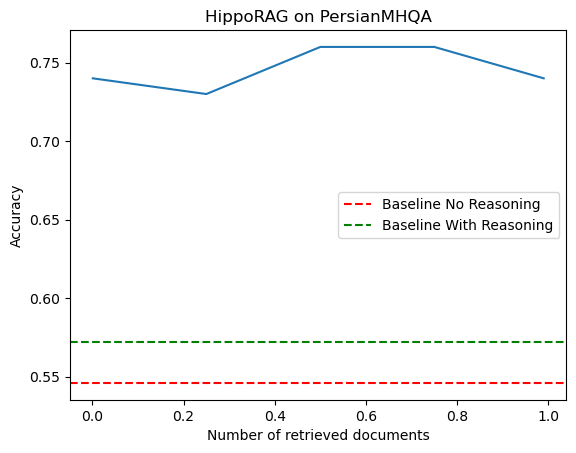

In [36]:
# plot the results
from matplotlib import pyplot as plt

plt.plot(accuracy_results.keys(), accuracy_results.values())
plt.xlabel('Number of retrieved documents')
plt.ylabel('Accuracy')
plt.title('HippoRAG on PersianMHQA')


plt.axhline(y=baseline_acc_no_reasoning, color='r', linestyle='--', label='Baseline No Reasoning')
plt.axhline(y=baseline_acc_reasoning, color='g', linestyle='--', label='Baseline With Reasoning')
plt.legend()

plt.show()